# "Diffusion Model Tutorial Using medMNISTv2 dataset"
by Miguel Xochicale 

### History 
* Dec 2022: Prototyped 


## Reference 
> Niels Rogge and Kashif Rasul (Published June 7th, 2022.)   
 https://huggingface.co/blog/annotated-diffusion
 
> Yang, Jiancheng, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, and Bingbing Ni. "Medmnist v2: A large-scale lightweight benchmark for 2d and 3d biomedical image classification." arXiv preprint arXiv:2110.14795 (2021). 
https://medmnist.com/ 



In [1]:
import os
import math
import time
import numpy as np


from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

from PIL import Image
import requests

import torch
import torch.nn.functional as F

from torch import nn, einsum
from torch.utils.data import DataLoader

import torchvision

print(f' torch.cuda.is_available(): {torch.cuda.is_available()}')



 torch.cuda.is_available(): True


In [2]:
mycwd = os.getcwd()
os.chdir("../..")
REPOSITORY_PATH =os.getcwd()
print(f' REPOSITORY_PATH: {REPOSITORY_PATH}')


 REPOSITORY_PATH: /home/mxochicale/repositories/mxochicale/diffusion-models-tutorials


In [3]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [5]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [7]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [8]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [9]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [10]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)
#betas = cosine_beta_schedule(timesteps=timesteps)
#betas = quadratic_beta_schedule(timesteps=timesteps)
#betas = sigmoid_beta_schedule(timesteps=timesteps)


# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)


# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [11]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        #print(f'x_start.shape: {x_start.shape}')#x_start.shape: torch.Size([1, 3, 128, 128])
        #print(f'x_start.dtype: {x_start.dtype}')#x_start.dtype: torch.float32
        noise = torch.randn_like(x_start)
        #print(f'noise.shape: {noise.shape}')#noise.shape: torch.Size([1, 3, 128, 128])
        #print(f'noise.dtype: {noise.dtype}')#noise.dtype: torch.float32


    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [12]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

In [13]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)
        #REF: https://pytorch.org/docs/stable/generated/torch.randn_like.html
        
        #torch.randn(input.size(), dtype=input.dtype, layout=input.layout, device=input.device).
        #noise = torch.randint(x_start.shape[0])
        #torch.randn_like(images) will try to sample random values 
        #from a gaussian distribution using the passed images properties such as its dtype. 
        # use another sampling (e.g. torch.randint).
        #https://discuss.pytorch.org/t/runtimeerror-normal-kernel-cpu-not-implemented-for-byte/139962
        

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## medMNISTv2 dataset

In [14]:
path_datasets_filename = REPOSITORY_PATH+'/datasets/MedMNISTv2/pathmnist.npz'
#Task: Multi-Class (9) Number of Samples: 107,180 (89,996 / 10,004 / 7,180)

print(path_datasets_filename)


/home/mxochicale/repositories/mxochicale/diffusion-models-tutorials/datasets/MedMNISTv2/pathmnist.npz


In [30]:
npz_file = np.load(path_datasets_filename)

print(type(npz_file)) #lib.npyio.NpzFile
print(npz_file.keys())#KeysView(<numpy.lib.npyio.NpzFile object at 0x7f5ac597d9f0>)

train_imgs = npz_file['train_images']
train_labels = npz_file['train_labels']
#             self.imgs = npz_file['val_images']
#             self.labels = npz_file['val_labels']
#             self.imgs = npz_file['test_images']
#             self.labels = npz_file['test_labels']

print(train_imgs.shape)#(546, 28, 28)
print(train_labels.shape)#(546, 1)
print(train_imgs.dtype) #uint8
length_samples = train_imgs.shape[0]



<class 'numpy.lib.npyio.NpzFile'>
KeysView(<numpy.lib.npyio.NpzFile object at 0x7f3640198d00>)
(89996, 28, 28, 3)
(89996, 1)
uint8


In [31]:
####### PREPARING TENSOR 

imagesTensor = torch.tensor(train_imgs)
print(imagesTensor.dtype) #uint8


IMAGE_SIZE = 28
CHANNELS = 3


print(type(imagesTensor))#<class 'torch.Tensor'>
print(imagesTensor.shape)#torch.Size([1080, 28, 28, 3])
imagesTensor = torch.permute(imagesTensor, (0, 3, 1, 2))
print(imagesTensor.shape)#torch.Size([1080, 28, 28, 3])

#####Transforms
#toTensor = torchvision.transforms.ToTensor()
#toPILImage = torchvision.transforms.ToPILImage()
# toResize = torchvision.transforms.Resize(image_size)
# toCenterCrop = torchvision.transforms.CenterCrop(image_size)
# toGraysacle = torchvision.transforms.Grayscale(num_output_channels=CHANNELS)



def scaleImage(x):
    #print(type(x)) #<class 'torch.Tensor'>
    #print(x.shape) #torch.Size([28, 28])

    if(x.min() < x.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min()) 
    z = x - x.mean()        # Subtract the mean value of the image
#     y = toTensor(y)
#     #y = toResize(y)
#     #y = toCenterCrop(y)
    
    return z

imageTensorX = torch.stack( [ scaleImage(x) for x in imagesTensor]  )
print(imageTensorX.shape)
print(type(imageTensorX))
print(imageTensorX.dtype)
# print(imageTensorX[0])#tensor([[[ 0.0597,  0.0440,  0.0597,  ...,  0.0597,  0.0440,  0.0753],


####imageTensorX = imagesTensor



##### CLASSES IN TENSORS
#FROM: Fig 1. Example images for each of the nine tissue classes represented in the NCT-CRC-HE-100K data set.

#ADI, adipose tissue; 
#BACK, background; 
#DEB, debris; 

#LYM, lymphocytes; 
#MUC, mucus; 
#MUS, smooth muscle; 

#NORM, normal colon mucosa; 
#STR, cancer-associated stroma; 
#TUM, colorectal adenocarcinoma epithelium.

##=====================================
#CRC, colorectal cancer; 
#HE, hematoxylin–eosin; 
#NCT, National Center for Tumor Diseases; 

batch_class00 = []
batch_class01 = []
batch_class02 = []
batch_class03 = []
batch_class04 = []
batch_class05 = []
batch_class06 = []
batch_class07 = []
batch_class08 = []

for idx in  range(0, length_samples):
    if train_labels[idx]==0:
        batch_class00.append(imageTensorX[idx])
    elif train_labels[idx]==1:
        batch_class01.append(imageTensorX[idx])
    elif train_labels[idx]==2:
        batch_class02.append(imageTensorX[idx])
    elif train_labels[idx]==3:
        batch_class03.append(imageTensorX[idx])
    elif train_labels[idx]==4:
        batch_class04.append(imageTensorX[idx])
    elif train_labels[idx]==5:
        batch_class05.append(imageTensorX[idx])
    elif train_labels[idx]==6:
        batch_class06.append(imageTensorX[idx])        
    elif train_labels[idx]==7:
        batch_class07.append(imageTensorX[idx])                
    elif train_labels[idx]==8:
        batch_class08.append(imageTensorX[idx])                        
    else:
        print('no class')

batch_class00 = torch.stack(batch_class00, 0)
batch_class01 = torch.stack(batch_class01, 0)
batch_class02 = torch.stack(batch_class02, 0)
batch_class03 = torch.stack(batch_class03, 0)
batch_class04 = torch.stack(batch_class04, 0)
batch_class05 = torch.stack(batch_class05, 0)
batch_class06 = torch.stack(batch_class06, 0)
batch_class07 = torch.stack(batch_class07, 0)
batch_class08 = torch.stack(batch_class08, 0)

print(f' batch_class00.shape {batch_class00.shape}')
print(f' batch_class01.shape {batch_class01.shape}')
print(f' batch_class02.shape {batch_class02.shape}')
print(f' batch_class03.shape {batch_class03.shape}')
print(f' batch_class04.shape {batch_class04.shape}')
print(f' batch_class05.shape {batch_class05.shape}')
print(f' batch_class06.shape {batch_class06.shape}')
print(f' batch_class07.shape {batch_class07.shape}')
print(f' batch_class08.shape {batch_class08.shape}')


torch.uint8
<class 'torch.Tensor'>
torch.Size([89996, 28, 28, 3])
torch.Size([89996, 3, 28, 28])
torch.Size([89996, 3, 28, 28])
<class 'torch.Tensor'>
torch.float32
 batch_class00.shape torch.Size([9366, 3, 28, 28])
 batch_class01.shape torch.Size([9509, 3, 28, 28])
 batch_class02.shape torch.Size([10360, 3, 28, 28])
 batch_class03.shape torch.Size([10401, 3, 28, 28])
 batch_class04.shape torch.Size([8006, 3, 28, 28])
 batch_class05.shape torch.Size([12182, 3, 28, 28])
 batch_class06.shape torch.Size([7886, 3, 28, 28])
 batch_class07.shape torch.Size([9401, 3, 28, 28])
 batch_class08.shape torch.Size([12885, 3, 28, 28])


In [69]:
TENSOR_BATCH = batch_class06
length_samples = TENSOR_BATCH.shape[0]

BATCH_SIZE=128
BATCHES_SIZE=length_samples/BATCH_SIZE
dataloader = DataLoader(TENSOR_BATCH, batch_size=BATCH_SIZE, shuffle=True)
print(f'BATCHES_SIZE {BATCHES_SIZE} or len(dataloader) {len(dataloader)}')


BATCHES_SIZE 61.609375 or len(dataloader) 62


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch_idx: 0; sampled images in the batch: 0 of 7886
    img.shape: torch.Size([128, 3, 28, 28])
    img.size: torch.Size([128, 3, 28, 28])
     torch.float32
    torch.Size([128, 3, 28, 28])
    torch.float32
    grid_img.shape: torch.Size([3, 482, 242])


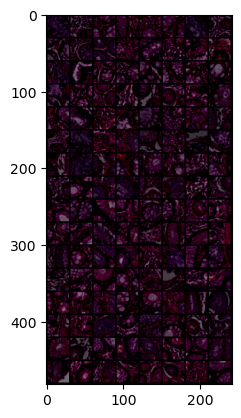

In [70]:
## Displaying dataloader content
len_dataloader = len(dataloader)

for batch_idx, batch in enumerate(dataloader):  #iterate through each batch    
    if batch_idx % 200 == 0:
        print(f'batch_idx: {batch_idx}; sampled images in the batch: { batch_idx*BATCH_SIZE } of {length_samples}')
        img = batch
        print(f'    img.shape: {img.shape}') #torch.Size([BATCH_SIZE, 1, 64, 64])
        print(f'    img.size: {img.size()}') #torch.Size([BATCH_SIZE, 1, 64, 64])
        
        #Testing types and shapes of tensors
        #noise = torch.randn_like(img)#RuntimeError: "normal_kernel_cpu" not implemented for 'Byte'
        print(f'     {img.dtype}')#torch.float32
        noise = torch.randn(img.size()) #, dypte=img.dtype, layout=img.layout)
        print(f'    {noise.shape}')#torch.Size([56, 1, 28, 28])
        print(f'    {noise.dtype}')#torch.float32

        grid_img = torchvision.utils.make_grid(img) #also (img, nrow=10)
        print(f'    grid_img.shape: {grid_img.shape}')#torch.Size([3, 482, 242])
        plt.imshow(grid_img.permute(1, 2, 0)) 
        #plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy().astype("uint8")) 
        plt.show()
    
  
    

In [71]:
batch = next(iter(dataloader))
# print(batch.keys()) ## print(batch.keys())
print(batch.shape)


torch.Size([128, 3, 28, 28])


In [72]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        #imgs.append(img.cpu().numpy())
        imgs.append(img)
    return imgs

@torch.no_grad()
def sample_model(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [73]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000


In [74]:
from torch.optim import Adam
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=IMAGE_SIZE,
    channels=CHANNELS,
    dim_mults=(1, 2, 4,)
)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)


cuda


In [75]:
# print(model)
# print(model.parameters())

In [76]:
from torchvision.utils import save_image

epochs = 10
batch_index_ratio=1000
losses = []

start_epoch_time = time.time()
for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    start_time = time.time_ns()

    for batch_index, batch in enumerate(dataloader):
        #optimizer.zero_grad()
        
        #print(batch.shape)#torch.Size([128, 1, 28, 28])
        batch_size = batch.shape[0] #128        
        batch = batch.to(device)
        


        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        # print(t.shape)#128 > Random vector from 0 to batch_size

        loss = p_losses(model, batch, t, loss_type="huber")
        #print(type(loss))#<class 'torch.Tensor'>
        #print(loss.shape)##print(type(loss))#<class 'torch.Tensor'>
        #print(loss.item())#0.05364229766726494
        #print(loss)#tensor(0.0536, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

        if batch_index % batch_index_ratio == 0:
            print(f'   Loss: {loss.item()} at batch_index {batch_index} of {len_dataloader}')


        loss.backward(loss)
        losses.append(loss.item())

        
        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()
        
        ## save generated images
        #if batch_index != 0 and batch_index % save_and_sample_every == 0:
        #    milestone = batch_index // save_and_sample_every
        #    batches = num_to_groups(4, batch_size)
        #    all_images_list = list(map(lambda n: sample_model(model, image_size=IMAGE_SIZE, batch_size=n, channels=CHANNELS), batches))
        #    all_images = torch.cat(all_images_list, dim=0)
        #    all_images = (all_images + 1) * 0.5
        #    save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
        
        
    elapsed_timens = time.time_ns() - start_time
    print(f'   Time: Single Epoch loop elapsed_time seconds {elapsed_timens/1000000000}')
    
    
elapsed_epoch_time = time.time() - start_epoch_time
print(f'Total epoch loop elapsed_time_secs {elapsed_epoch_time}')
print(f'Total epoch loop {time.strftime("%H:%M:%S", time.gmtime(elapsed_epoch_time))} (H:M:S) ')

Epoch: 0
   Loss: 0.45809313654899597 at batch_index 0 of 62
   Time: Single Epoch loop elapsed_time seconds 11.399211988
Epoch: 1
   Loss: 0.36072826385498047 at batch_index 0 of 62
   Time: Single Epoch loop elapsed_time seconds 11.449654226
Epoch: 2
   Loss: 0.1915488988161087 at batch_index 0 of 62
   Time: Single Epoch loop elapsed_time seconds 11.492590122
Epoch: 3
   Loss: 0.11783897876739502 at batch_index 0 of 62
   Time: Single Epoch loop elapsed_time seconds 11.507129878
Epoch: 4
   Loss: 0.08386949449777603 at batch_index 0 of 62
   Time: Single Epoch loop elapsed_time seconds 11.511768434
Epoch: 5
   Loss: 0.07509488612413406 at batch_index 0 of 62
   Time: Single Epoch loop elapsed_time seconds 11.539512888
Epoch: 6
   Loss: 0.06657442450523376 at batch_index 0 of 62
   Time: Single Epoch loop elapsed_time seconds 11.55683302
Epoch: 7
   Loss: 0.0648442730307579 at batch_index 0 of 62
   Time: Single Epoch loop elapsed_time seconds 11.566254816
Epoch: 8
   Loss: 0.0644376

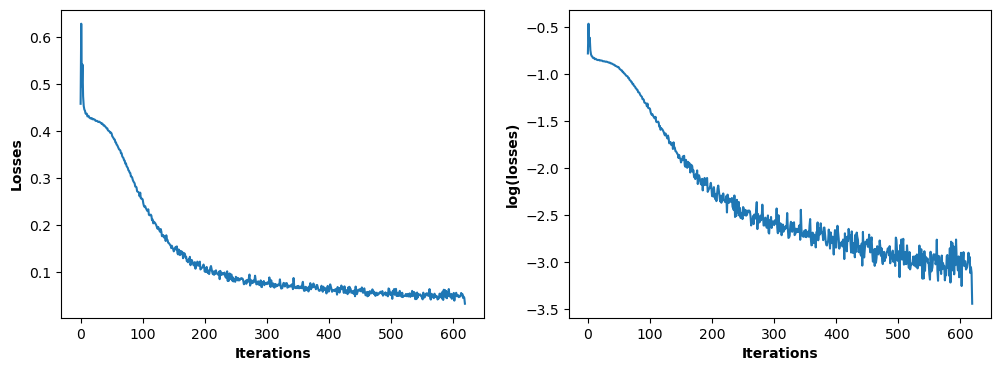

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[0].set_ylabel('Losses', fontweight ="bold")
axs[0].set_xlabel('Iterations', fontweight ="bold")

axs[1].plot(np.log(losses))
axs[1].set_ylabel('log(losses)', fontweight ="bold")
axs[1].set_xlabel('Iterations', fontweight ="bold")

plt.show()

In [78]:
# sample BATCH_SIZE images
BATCH_SIZE_FOR_SAMPLES = BATCH_SIZE
IMAGE_SIZE_SAMPLES = 28
CHANNELS_SAMPLES = CHANNELS
samples = sample_model(model, 
                       image_size=IMAGE_SIZE_SAMPLES, 
                       batch_size=BATCH_SIZE_FOR_SAMPLES, 
                       channels=CHANNELS_SAMPLES)


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [79]:
print(type(samples)) #<class 'list'>

print(f'len(samples): {len(samples)}') #len(samples): 200?
#print(samples[0][0].shape) 
print(samples[0].shape) 
#torch.Size([BATCH_SIZE_FOR_SAMPLES, CHANNELS_SAMPLES, IMAGE_SIZE_SAMPLES, IMAGE_SIZE_SAMPLES])
#print(samples[0][0].shape) 


<class 'list'>
len(samples): 200
torch.Size([128, 3, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 0
samples_img.shape: torch.Size([128, 3, 28, 28])


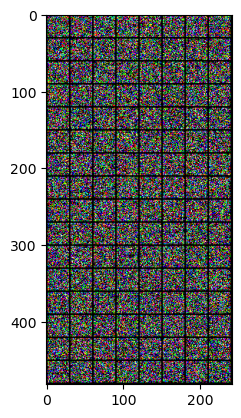

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 20
samples_img.shape: torch.Size([128, 3, 28, 28])


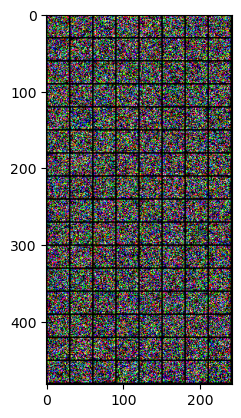

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 40
samples_img.shape: torch.Size([128, 3, 28, 28])


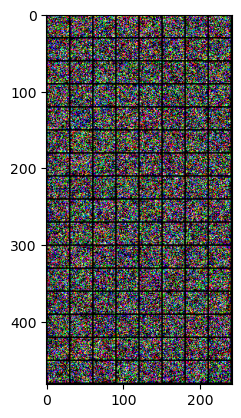

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 60
samples_img.shape: torch.Size([128, 3, 28, 28])


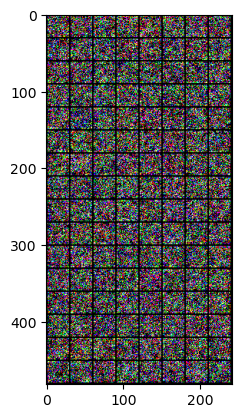

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 80
samples_img.shape: torch.Size([128, 3, 28, 28])


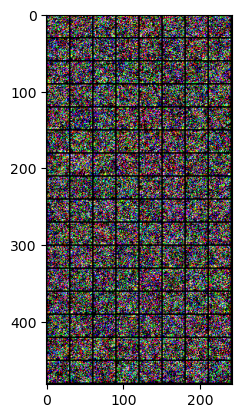

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 100
samples_img.shape: torch.Size([128, 3, 28, 28])


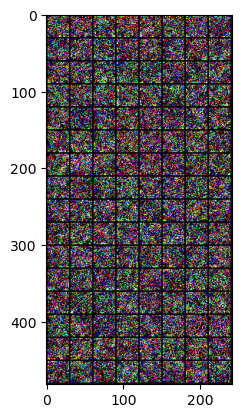

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 120
samples_img.shape: torch.Size([128, 3, 28, 28])


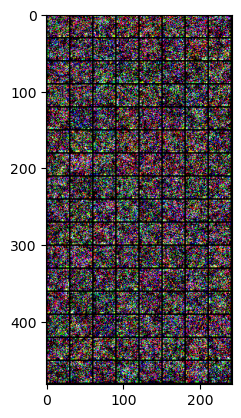

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 140
samples_img.shape: torch.Size([128, 3, 28, 28])


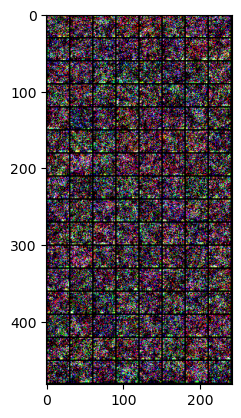

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 160
samples_img.shape: torch.Size([128, 3, 28, 28])


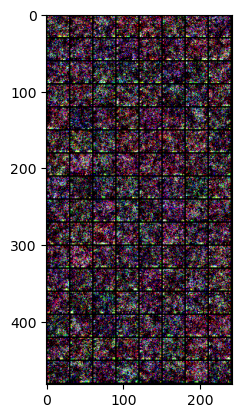

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samples_idx: 180
samples_img.shape: torch.Size([128, 3, 28, 28])


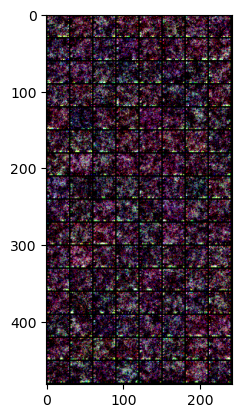

In [80]:
## show a batches 
for samples_idx, samples_img in enumerate(samples):    
    if samples_idx % 20 == 0:
        print(f'samples_idx: {samples_idx}')
        print(f'samples_img.shape: {samples_img.shape}') #torch.Size([64, 1, 28, 28])
        grid_img = torchvision.utils.make_grid(samples_img)
        #grid_img = torchvision.utils.make_grid(samples_img, nrow=30)
        #print(f'grid_img.shape: {grid_img.shape}') #torch.Size([3, 122, 602])
        plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy()) 
        #plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy().astype("uint8")) 
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


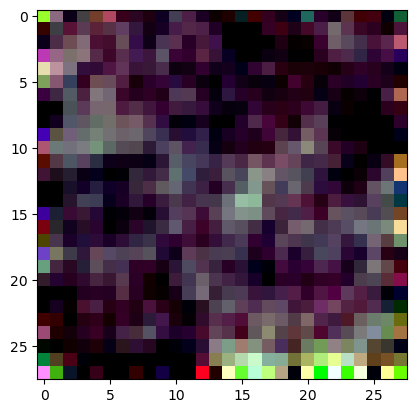

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


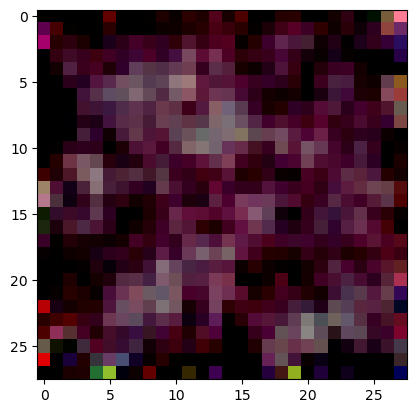

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


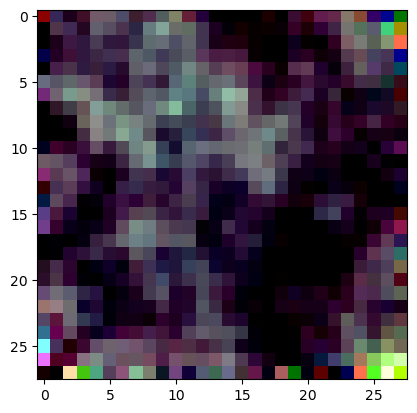

In [81]:
## show a random one
random_index = 0
plt.imshow(samples[-1][random_index].permute(1, 2, 0).cpu().numpy()) 
plt.show()

random_index = 1
plt.imshow(samples[-1][random_index].permute(1, 2, 0).cpu().numpy()) 
plt.show()

random_index = 2
plt.imshow(samples[-1][random_index].permute(1, 2, 0).cpu().numpy()) 
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

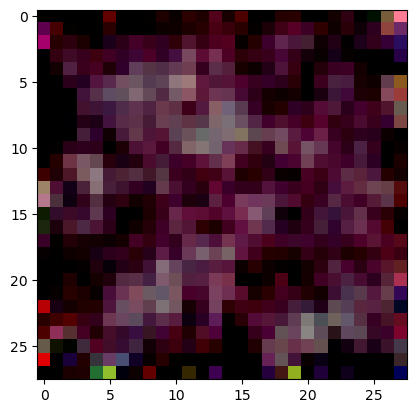

In [83]:
import matplotlib.animation as animation
from IPython.display import HTML #for HTML(animation.ArtistAnimation().to_jshtml())

random_index = 1

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].permute(1, 2, 0).cpu().numpy(), animated=True) 
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
HTML(animate.to_jshtml())      


In [84]:
results_path = REPOSITORY_PATH+'/tutorials/results'
print(results_path)
os.chdir(results_path)


/home/mxochicale/repositories/mxochicale/diffusion-models-tutorials/tutorials/results


In [86]:
##Save animation
animate.save('animation_pathmnistV00.gif', writer='imagemagick', fps=60)

In [87]:
torch.save(model, 'model_pathmnistV00')

In [88]:
ls -la

total 98808
drwxrwxr-x 2 mxochicale mxochicale     4096 Dec 29 13:39 ./
drwxrwxr-x 7 mxochicale mxochicale     4096 Dec 29 10:25 ../
-rw-rw-r-- 1 mxochicale mxochicale  8039973 Dec 29 10:16 animation_class01_breastmnist.gif
-rw-rw-r-- 1 mxochicale mxochicale  7910525 Dec 20 09:10 animation_difussion_sample.gif
-rw-rw-r-- 1 mxochicale mxochicale  8030787 Dec 27 17:10 animation_medNIST.gif
-rw-rw-r-- 1 mxochicale mxochicale 10956561 Dec 29 13:38 animation_pathmnistV00.gif
-rw-rw-r-- 1 mxochicale mxochicale  8212992 Dec 28 17:39 animation_retinamnistV00.gif
-rw-rw-r-- 1 mxochicale mxochicale  9551740 Dec 29 11:55 animation_retinamnistV01.gif
-rw-rw-r-- 1 mxochicale mxochicale    66031 Dec 29 10:16 model_breastmnist
-rw-rw-r-- 1 mxochicale mxochicale 12089225 Dec 27 17:11 model_medNIST
-rw-rw-r-- 1 mxochicale mxochicale 12096521 Dec 29 13:39 model_pathmnistV00
-rw-rw-r-- 1 mxochicale mxochicale 12096521 Dec 29 11:53 model_retinamnistv01
-rw-rw-r-- 1 mxochicale mxochicale 12096521 Dec 29 11

In [89]:
os.chdir(REPOSITORY_PATH)     # go back where you came from